In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c
from mc_sspals import initialize, convert
from mc_sspals.laser import Laser, Transition, fluence, doppler, overlap
import seaborn as sns                                       # statistics/ plotting
sns.set(style="ticks", font_scale=1.25)

In [3]:
# positrons
num = int(1e6)
sigma_x = 1e-3
sigma_t = 2e-9
# converter
eff = 0.25
T = 400
# Lyman-alpha
lyman_alpha = Transition(wavelength=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
threshold = 0.002
uv = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)

In [4]:
df = initialize(num, sigma_t=sigma_t, sigma_x=sigma_x)
df = convert(df, eff=eff, T=T)
df.head()

,status,lifetime,ti,xi,yi,zi,vx,vy,vz
0,e+,0.0,2.429221e-09,0.001195,0.000745,0.0,NaN,NaN,NaN
1,e+,0.0,-1.030217e-09,0.002230,0.000987,0.0,NaN,NaN,NaN
2,e+,0.0,2.922346e-09,0.000847,-0.000294,0.0,NaN,NaN,NaN
3,e+,0.0,1.481622e-09,-0.000844,0.002119,0.0,NaN,NaN,NaN
4,e+,0.0,-1.838167e-09,-0.000383,-0.000274,0.0,NaN,NaN,NaN


In [5]:
flu = fluence(df, uv)
dop = doppler(df, uv, lyman_alpha)
ol = overlap(df, uv, lyman_alpha)

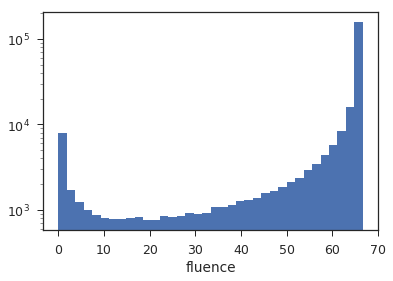

In [6]:
fig, ax = plt.subplots()
ax.hist(flu, 36)
ax.set_xlabel('fluence')
ax.set_yscale('log')
plt.show()

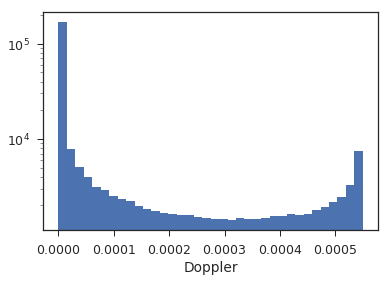

In [7]:
fig, ax = plt.subplots()
ax.hist(dop, 36)
ax.set_xlabel('Doppler')
ax.set_yscale('log')
plt.show()

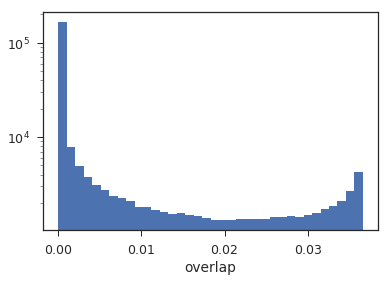

In [8]:
fig, ax = plt.subplots()
ax.hist(ol, 36)
ax.set_xlabel('overlap')
ax.set_yscale('log')
plt.show()

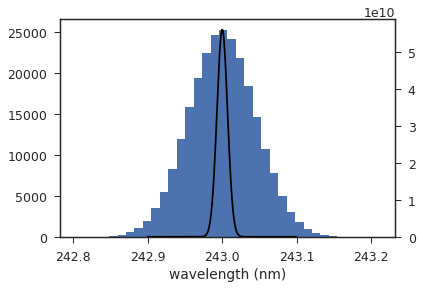

In [9]:
fig, ax1 = plt.subplots()

# MC doppler
dop = (lyman_alpha.wavelength * (1.0 - df.vx / c))
ax1.hist(dop.dropna() * 1e9, 36)
wl = np.linspace(242.9, 243.1, 300) * 1e-9

# laser
ax2 = ax1.twinx()
ax2.plot(wl*1e9, uv.lineshape(wl), label='laser', c='k')

# format
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_xlabel('wavelength (nm)')
plt.show()

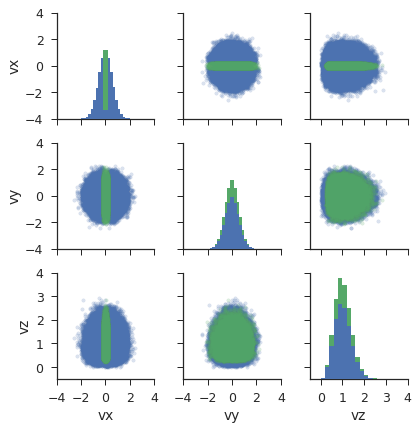

In [10]:
atoms = df[df.status != 'e+']
atoms = atoms.join(ol)
threshold = 0.003
atoms['ex'] = atoms['overlap'] > threshold
atoms[['vx', 'vy', 'vz']] = atoms[['vx', 'vy', 'vz']] *1e-5

# plot
bins = np.linspace(-4, 4, 41)
g = sns.PairGrid(atoms, vars=['vx', 'vy', 'vz'], hue='ex')
g = g.map_diag(plt.hist, bins=bins, rwidth=1, lw=0., normed=True)
g = g.map_offdiag(plt.scatter, alpha=0.2, marker='.', rasterized=True)


# format
g.fig.set_size_inches((6, 6))
g.axes[0][0].set_xlim((-4., 4.))
g.axes[0][0].set_xticks([-4, -2, 0, 2, 4])
g.axes[0][1].set_xlim((-4., 4.))
g.axes[0][1].set_xticks([-4, -2, 0, 2, 4])
g.axes[0][2].set_xlim((-0.5, 4.))
g.axes[0][2].set_xticks([0, 1, 2, 3, 4])
g.axes[0][0].set_ylim((-4., 4.))
g.axes[0][0].set_yticks([-4, -2, 0, 2, 4])
g.axes[1][0].set_ylim((-4., 4.))
g.axes[1][0].set_yticks([-4, -2, 0, 2, 4])
g.axes[2][0].set_ylim((-0.5, 4.))
g.axes[2][0].set_yticks([0, 1, 2, 3, 4])

#output
plt.savefig("../images/mc_vel.pdf", dpi=200, bbox_inches='tight')
plt.show()